### LSUN Bedroom Generator

In [1]:
import torch
from torch import nn
from torch import optim
from torch.optim import lr_scheduler
from torch.utils.data import default_collate

import numpy as np

from torchvision.io import read_image, ImageReadMode
from torchvision import transforms
from torch.utils.data import DataLoader

import fastcore.all as fc
from fastprogress import progress_bar
from fastai.callback.hook import Hooks

from diffusers import AutoencoderKL, UNet2DModel
from diffusers import DDPMScheduler, DDIMScheduler
from diffusers.models.resnet import ResnetBlock2D

from torchmetrics.image.fid import FrechetInceptionDistance
from torchmetrics.image.kid import KernelInceptionDistance

import matplotlib.pyplot as plt

D:\AI_Bender\Fast_ai\venv_fast\lib\site-packages\torchaudio\backend\utils.py:74: UserWarning: No audio backend is available.
  warnings.warn("No audio backend is available.")


In [2]:
from pathlib import Path
import shutil
from glob import glob
from functools import partial
from itertools import islice

from miniai.init import clean_mem
from miniai.datasets import show_image, show_images
from miniai.learner import to_cpu, Learner, Callback, DeviceCB, ProgressCB, MetricsCB
from miniai.diffusion2 import noisify
from miniai.sgd import BatchSchedCB
from miniai.accel import MixedPrecision
from miniai.training import get_dls
from miniai.datasets import DataLoaders
from miniai.fid import ImageEval
from miniai.activations import ActivationStatsMod, set_seed

from miniai_extend.sampling import sampling, latents_to_images
from miniai_extend.evaluation import SamplesEval

### ----------------------------------------

### Hyperparameter

In [3]:
bs = 32

lr = 1e-3
epochs = 5
adam_eps = 1e-5

### Device

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

### Config

In [5]:
figsize_img = (2, 2)
figsize_stats = (10, 2)
figsize_cld = (10, 2)
figsize_cldz = (10, 1)
figsize_dead = (10, 4)

### ----------------------------------------

### Data

#### Data origin

In [6]:
path_data = Path("data/")
path_data.mkdir(exist_ok= True)
path_bedroom = path_data/"bedroom/"
path_bedroom

Path('data/bedroom')

In [7]:
url = 'https://s3.amazonaws.com/fast-ai-imageclas/bedroom.tgz'
if not path_bedroom.exists():
    path_zip = fc.urlsave(url, path_data)
    shutil.unpack_archive("data/bedroom.tgz", "data")

#### ----------

#### Data subbing

In [8]:
n_imgs = 10000
path_sub = path_data/f"bedroom_{n_imgs}"
path_sub

Path('data/bedroom_10000')

In [9]:
%%time

if not path_sub.exists():
    path_sub.mkdir()

    img_paths = glob(str(path_bedroom/f"**/*.jpg"), recursive= True)
    scr_img_paths = img_paths[:n_imgs]
    dest_img_paths = [path_sub/Path(x).name for x in scr_img_paths]

    [shutil.copy(scr, dest) for scr, dest in zip(scr_img_paths, dest_img_paths)]

CPU times: total: 0 ns
Wall time: 0 ns


### ----------------------------------------

### Data Processing

#### Data class

In [10]:
def to_tensor(img): return read_image(img, mode= ImageReadMode.RGB)/255

In [11]:
class ImagesDS():

    def __init__(self, path, spec= ".jpg"):

        self.path = Path(path)
        self.files = glob(str(path/f"**/*{spec}"), recursive= True)

    def __len__(self): return len(self.files)
    def __getitem__(self, i): return to_tensor(self.files[i]), self.files[i]
    def __repr__(self): return f"{len(self.files)} items"
        

In [12]:
dts = ImagesDS(path_sub)
dts, dts[0][0].shape, dts[0][1]

(10000 items,
 torch.Size([3, 256, 341]),
 'data\\bedroom_10000\\000038527b455eaccd15e623f2e229ecdbceba2b.jpg')

#### ----------

#### Mean | Std | Original

In [13]:
imgs_mean = 0.5178
imgs_std = 0.2395

#### ----------

#### Visualize Image

In [14]:
def show_image_mod(image, figsize= figsize_img, clamp= True):

    if clamp: image = image.clamp(0, 1)
    show_image(image, figsize= figsize)

def show_images_mod(images, imsize= 1., clamp= True):

    if clamp: images = images.clamp(0, 1)
    show_images(images, imsize= imsize)

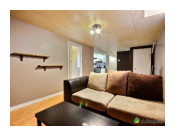

In [15]:
show_image_mod(dts[0][0])

#### ----------

#### Transforms

In [16]:
tfmx = transforms.Compose(
    [
        transforms.Resize((256, 256), antialias= True)])

In [17]:
class ImagesDSTfm():

    def __init__(self, dts, tfmx= fc.noop, tfmy= fc.noop): fc.store_attr()
    def __len__(self): return len(self.dts)
    def __getitem__(self, i): return self.tfmx(self.dts[i][0]), self.tfmy(self.dts[i][1])
    def __repr__(self): return f"{self.dts} with transforms"

In [18]:
dts_tfm = ImagesDSTfm(dts, tfmx= tfmx)
dts_tfm, dts_tfm[0][0].shape, dts_tfm[0][1]

(10000 items with transforms,
 torch.Size([3, 256, 256]),
 'data\\bedroom_10000\\000038527b455eaccd15e623f2e229ecdbceba2b.jpg')

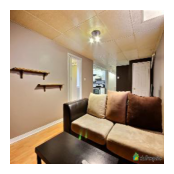

In [19]:
show_image_mod(dts_tfm[0][0])

#### ----------

#### Mean | Std | Transforms

In [20]:
#NoNorm
imgs_tfm_mean = 0.5178
imgs_tfm_std = 0.2371

### ----------------------------------------

### DataLoader

In [21]:
dls = DataLoader(dts_tfm, batch_size= bs, shuffle= True)
xb, yb = next(iter(dls))
xb.shape

torch.Size([32, 3, 256, 256])

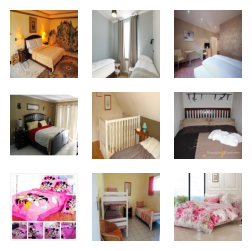

In [22]:
show_images_mod(xb[:9])

### ----------------------------------------

### VAE

In [23]:
vae = AutoencoderKL.from_pretrained("stabilityai/sd-vae-ft-ema").requires_grad_(False).to(device)

#### Latents

In [24]:
path_ltt = path_data/f"bedroom_{n_imgs}_latents_nonorm/"
path_ltt

Path('data/bedroom_10000_latents_nonorm')

In [25]:
if not path_ltt.exists():
    path_ltt.mkdir()

    for imgs, paths in progress_bar(dls):

        ltts = vae.encode(imgs.to(device))
        ltts_m_np = to_cpu(ltts.latent_dist.mean).numpy()

        [np.save(path_ltt/Path(p).with_suffix(".npy").name, ltt)
         for p, ltt in zip(paths, ltts_m_np)]

### ----------------------------------------

### Data Splitting

In [26]:
path_trn = Path(f"{path_ltt}_train/")
path_val = Path(f"{path_ltt}_valid/")
path_trn, path_val

(Path('data/bedroom_10000_latents_nonorm_train'),
 Path('data/bedroom_10000_latents_nonorm_valid'))

In [27]:
split_portion = 0.1
n_trn = int(n_imgs * (1-split_portion))
n_trn

9000

In [28]:
%%time

if not path_trn.exists() or not path_val.exists():
    path_trn.mkdir()
    path_val.mkdir()

    ltt_files = glob(f"{path_ltt}/**/*.npy", recursive= True)
    ltt_files_trn = ltt_files[:n_trn]
    ltt_files_val = ltt_files[n_trn:]

    [shutil.copy(p, path_trn/Path(p).name) for p in ltt_files_trn]
    [shutil.copy(p, path_val/Path(p).name) for p in ltt_files_val]

CPU times: total: 0 ns
Wall time: 0 ns


### ----------------------------------------

### Latents Dataset

#### Data Class

In [29]:
class NumpyDS(ImagesDS):

    def __getitem__(self, i): return torch.from_numpy(np.load(self.files[i])), self.files[i]

In [30]:
dts_trn = NumpyDS(path_trn, spec= ".npy")
dts_trn, dts_trn[0][0].shape, dts_trn[0][1]

(9000 items,
 torch.Size([4, 32, 32]),
 'data\\bedroom_10000_latents_nonorm_train\\000038527b455eaccd15e623f2e229ecdbceba2b.npy')

In [31]:
dts_val = NumpyDS(path_val, spec= ".npy")
dts_val, dts_val[0][0].shape, dts_val[0][1]

(1000 items,
 torch.Size([4, 32, 32]),
 'data\\bedroom_10000_latents_nonorm_valid\\073bf236c811160148e09bb29b1409f649add958.npy')

#### ----------

#### Mean | Std | Latents

In [32]:
#NoNorm
ltts_mean = 1.7197
ltts_std = 4.8114

#### ----------

#### Dataloader

In [33]:
set_seed(42)

In [34]:
def collate_ddpm(b): return noisify(default_collate(b)[0]*0.2)

In [35]:
dls = DataLoaders(*get_dls(dts_trn, dts_val, bs= bs, collate_fn= collate_ddpm))

### ----------------------------------------

### Training

In [36]:
class TrainLearner(Learner):

    def predict(self): self.preds = self.model(*self.batch[0]).sample
    def get_loss(self): self.loss = self.loss_func(self.preds, self.batch[1])
    def backward(self): self.loss.backward()
    def step(self): self.opt.step()
    def zero_grad(self): self.opt.zero_grad()

#### ----------

#### ResnetBlock: GroupNorm -> LayerNorm

In [37]:
def return_inp_shape(model, input, output): return input[0].shape

def get_modules_inp_shapes(model, dls, spec):

    attn_norm_modules = [m for n, m in model.named_modules() if n.endswith(spec)]
    attn_norm_hooks = Hooks(attn_norm_modules, return_inp_shape)

    device = model.device
    inps, _ = next(iter(dls.train))
    model(inps[0].to(device), inps[1].to(device))
    
    return attn_norm_hooks.stored

In [38]:
def resnets_layernorm(model, dls):

    lnorm_gen = partial(nn.LayerNorm, eps= 1e-5, elementwise_affine= True)

    norm1_inp_shape = get_modules_inp_shapes(model, dls, spec= "norm1")
    norm1_inp_shape = reversed(norm1_inp_shape)
    
    norm2_inp_shape = get_modules_inp_shapes(model, dls, spec= "norm2")
    norm2_inp_shape = reversed(norm2_inp_shape)

    for m in model.modules():

        if m.__class__.__name__ == "ResnetBlock2D":

            shape1 = norm1_inp_shape.pop()
            m.norm1 = lnorm_gen(shape1[1:])

            shape2 = norm2_inp_shape.pop()
            m.norm2 = lnorm_gen(shape2[1:])

#### Attention: GroupNorm -> LayerNorm

In [39]:
def return_inp_shape(model, input, output): return input[0].shape

def get_modules_inp_shapes(model, dls, spec):

    attn_norm_modules = [m for n, m in model.named_modules() if n.endswith(spec)]
    attn_norm_hooks = Hooks(attn_norm_modules, return_inp_shape)

    device = model.device
    inps, _ = next(iter(dls.train))
    model(inps[0].to(device), inps[1].to(device))
    
    return attn_norm_hooks.stored

In [40]:
def attentions_layernorm(model, dls):

    attn_norm_shapes = get_modules_inp_shapes(model, dls, spec= "group_norm")
    attn_norm_shapes = reversed(attn_norm_shapes)

    lnorm_gen = partial(nn.LayerNorm, eps= 1e-5, elementwise_affine= True)

    for m in model.modules():

        if m.__class__.__name__ == "Attention":

            shape = attn_norm_shapes.pop()
            m.group_norm = nn.LayerNorm(normalized_shape= [shape[1], shape[2]]) 

#### ----------

#### Init Unet

In [41]:
def init_unet(model, spec= "conv2"):

    for name, module in model.named_modules():
        
        if name.endswith(spec): 
            with torch.no_grad(): module.weight.zero_()

In [42]:
model = UNet2DModel(in_channels= 4, out_channels= 4, block_out_channels= (32, 64, 64, 128))

resnets_layernorm(model, dls)
attentions_layernorm(model, dls)
init_unet(model, spec= "conv2")

#### ----------

#### Train

In [43]:
loss_func = nn.MSELoss()
opt_func = partial(optim.AdamW, eps= adam_eps)

total_steps = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr= lr, total_steps= total_steps)

act_stats = ActivationStatsMod(fc.risinstance(ResnetBlock2D))

cbs = [DeviceCB(), ProgressCB(plot= True), MetricsCB(), BatchSchedCB(sched), MixedPrecision(), act_stats]
learn = TrainLearner(model, dls, loss_func= loss_func, lr= lr, cbs= cbs, opt_func= opt_func)

loss,epoch,train
0.546,0,train
0.340,0,eval
0.334,1,train
0.332,1,eval
0.325,2,train
0.318,2,eval
0.318,3,train
0.308,3,eval
0.313,4,train
0.297,4,eval


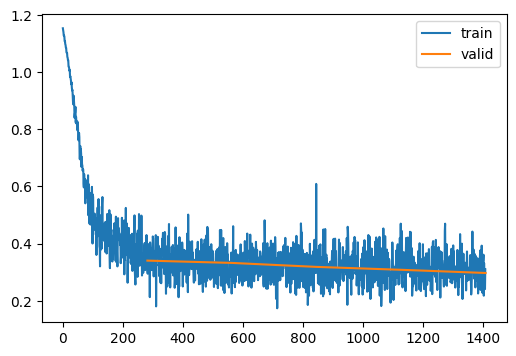

CPU times: total: 50min 15s
Wall time: 6min 27s


In [44]:
%%time

learn.fit(epochs)

### ----------------------------------------

### Activation Stats

In [45]:
def show_act_stats(act_stats, n_chart= 10):

    act_stats.plot_stats(figsize= figsize_stats, n_chart= n_chart)
    # act_stats.color_dim(figsize= figsize_cld, n_chart= n_chart)
    act_stats.color_dim_zoom(figsize= figsize_cldz, n_chart= n_chart)
    act_stats.dead_chart(figsize= figsize_dead, n_chart= n_chart)

D:\AI_Bender\Fast_ai\Practical_DL_adv\image_generator\miniai\datasets.py:59: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig,ax = plt.subplots(nrows, ncols, figsize=figsize, **kwargs)


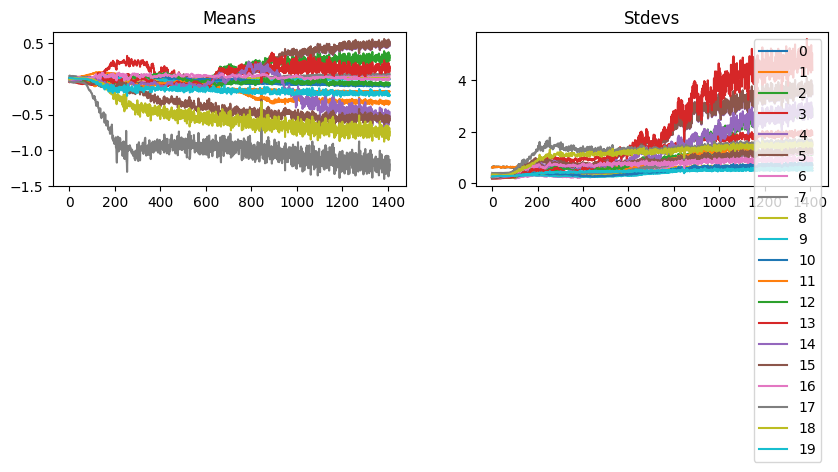

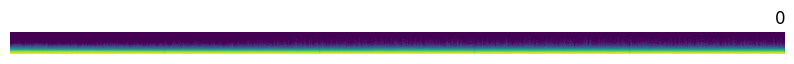

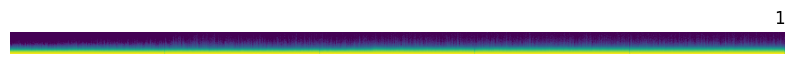

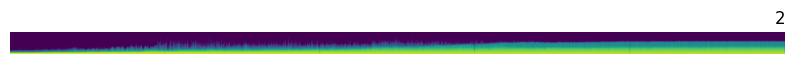

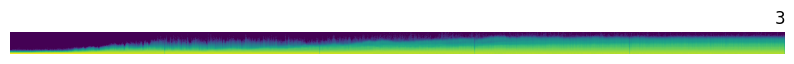

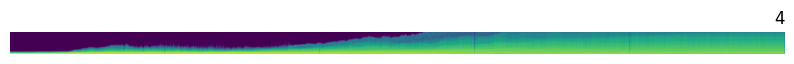

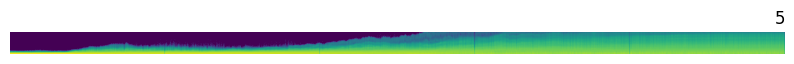

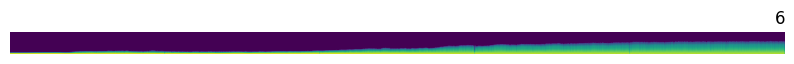

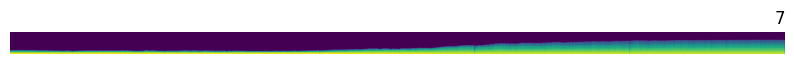

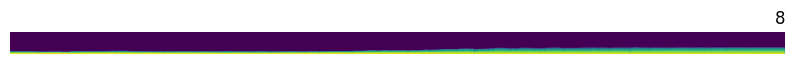

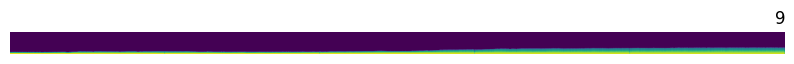

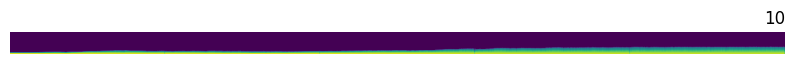

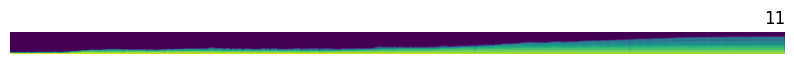

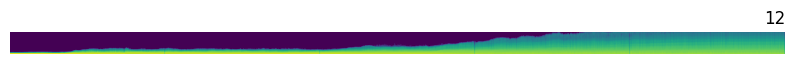

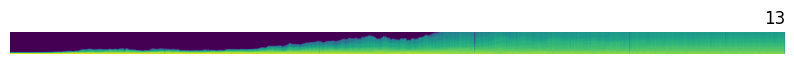

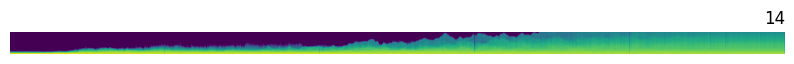

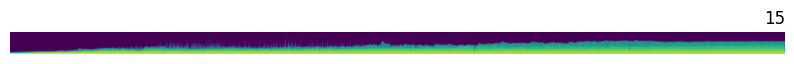

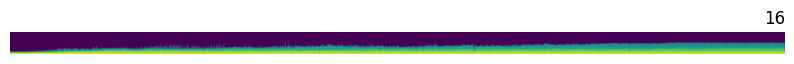

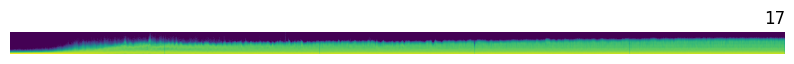

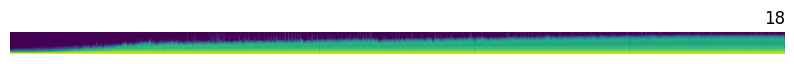

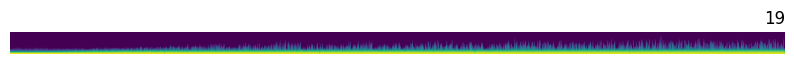

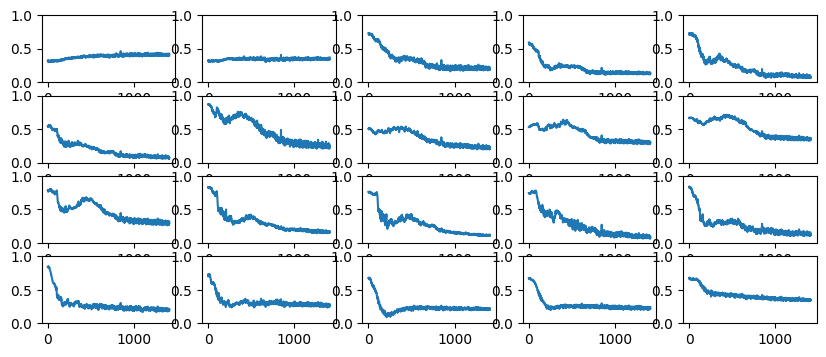

In [46]:
show_act_stats(act_stats, n_chart= 20)

### ----------------------------------------

### Sampling

#### DDIM

In [47]:
sched = DDIMScheduler(beta_end= 0.01)
steps = 1000
size = (32, 4, 32, 32)
eta = 1

samples = sampling(sched, learn.model, steps= steps, size= size, eta= eta)

In [48]:
%%time

s = samples[-1]*5
with torch.no_grad(): imgs_ddim = latents_to_images(vae, s, clamp= True, device= device)
imgs_ddim.shape

CPU times: total: 33.5 s
Wall time: 35.1 s


torch.Size([32, 3, 256, 256])

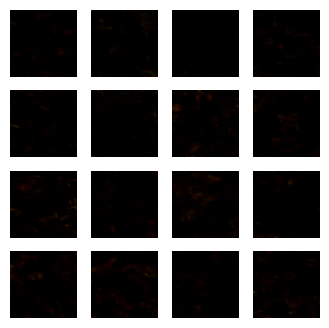

In [49]:
show_images_mod(imgs_ddim[:16])

### ----------------------------------------

### Evaluation

In [50]:
dls_eval = DataLoader(dts_tfm, batch_size= bs, shuffle= False)

imgs_eval, _ = next(iter(dls_eval))
imgs_eval.shape, imgs_eval.dtype

(torch.Size([32, 3, 256, 256]), torch.float32)

In [51]:
percent_eval = 0.5

samples_eval = SamplesEval(dls_eval, percent= percent_eval, device= device)
samples_eval.init_kid(feature= 2048, subset_size= 32, reset_real_features= False)

D:\AI_Bender\Fast_ai\venv_fast\lib\site-packages\torchmetrics\utilities\prints.py:43: UserWarning: Metric `Kernel Inception Distance` will save all extracted features in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)  # noqa: B028


In [52]:
mult = 1e4

In [53]:
#Origin
kid_ori = samples_eval.kid_eval(imgs_eval)
kid_ori[0] * mult, kid_ori[1]

(tensor(-1.1971, device='cuda:0'), tensor(0.0002, device='cuda:0'))

In [54]:
#Sample
kid_samples = samples_eval.kid_eval(imgs_ddim)
kid_samples[0] * mult, kid_samples[1]

(tensor(24.2682, device='cuda:0'), tensor(0.0010, device='cuda:0'))

### ----------------------------------------